## GANs : Generative Adversarial Networks 


Image from [here]()
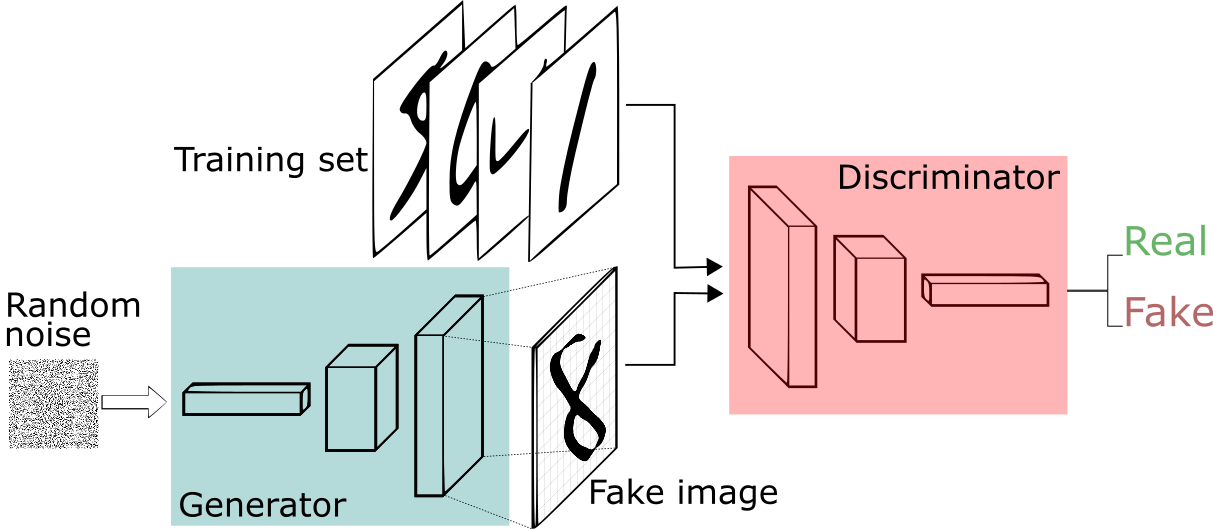

# Submission by: Pragyendra Bagediya

# Uni: PB2861

Official Tutorial referred: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

Generator output - 28X28

Discriminator Output - 1

A generative adversarial network (GAN) is a generative model composed of two neural networks: a generator and a discriminator. These two networks are trained in unsupervised way via competition. The generator creates ”realistic” fake images from random noise to fool the discriminator, while the discriminator evaluates the given image for authenticity. 
The loss function that the generator wants to minimize and the discriminator to maximize is as follows: 

min G max D L(D, G) = Ex∼pdata(x)[log D(x)] + Ez∼pz(z)[log(1 − D(G(z)))] 

Here, G and D are the generator and the discriminator. The first and second term of the loss represent the correct prediction of the discriminator on the real images and on the fake images respectively. 




## DCGAN

• You will implement deep convolutional GAN model on the MNIST dataset with Pytorch. The input image size is 28 x 28. 

• The details of the generator of DCGAN is described below. 

• You will start with batch size of 128, input noise of 100 dimension and Adam optimizer with learning rate of 2e-4. You may vary these hyperparameters for better performance. 

## Architectures


Generator: 

The goal for the generator is to use layers such as convolution, maybe also upsampling layer/transposedConvolution to produce image from the given input noise vector. As this is DCGAN (deep convolutional GAN), we expect you to use convolution in the generator. You will get full credit if you can produce `[batchsize, 1, 28, 28]` vector (image) from the given `[batchsize, 100, 1, 1]` vector (noise).

Linear Layers that you may use:

• torch.nn.Conv2d

• torch.nn.UpsamplingBilinear2d

• torch.nn.ConvTranspose2d

Non-linear layer: 
 
• torch.nn.LeakyReLU with slope=0.2 between all linear layers.

• torch.nn.Tanh for the last layer's activation. Can you explain why do we need this in the code comment?


You may use `view` to change the vector size: https://pytorch.org/docs/stable/generated/torch.Tensor.view.html 

We recommend to use 2 Conv/TransposedConv layers. When you are increasing the feature map size, considering upsample the feature by a factor of 2 each time. If you have width of 7 in one of your feature map, to get output with width of 28, you can do upsampling with factor of 2 and upsampling 2 times. 

Discriminator:

You will get full credit if you can produce an output of `[batchsize, 1]` vector (image) from the given input `[batchsize, 1, 28, 28]` vector (noise).

Linear Layers that you may use:

• torch.nn.Conv2d

• torch.nn.Linear

Non-linear Layers: 

• torch.nn.LeakyReLU with slope=0.2 between all linear layers.

• torch.nn.Sigmoid for the last layer's activation. Can you explain why do we need this in the code comment?

Use Leaky ReLu as the activation function between all layers, except after the last layer use Sigmoid.

You may use `view` to change the vector size: https://pytorch.org/docs/stable/generated/torch.Tensor.view.html 

As an example, you may use 2 convolution layer and one linear layer in the discriminator, you can also use other setup. Note that instead of using pooling to downsampling, you may also use stride=2 in convolution to downsample the feature.

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
from torch.optim.lr_scheduler import StepLR
import torchvision.utils as vutils
from torch.utils.data import DataLoader, TensorDataset
from scipy import linalg
from scipy.stats import entropy
import tqdm
import cv2
torch.manual_seed(0)

# image input size
image_size=28

# Setting up transforms to resize and normalize 
transform=transforms.Compose([
                               transforms.ToTensor(),
                               ])
# batchsize of dataset
batch_size = 100

# Load MNIST Dataset
gan_train_dataset = datasets.MNIST(root='./MNIST/', train=True, transform=transform, download=True)
gan_train_loader = torch.utils.data.DataLoader(dataset=gan_train_dataset, batch_size=batch_size, shuffle=True)



## Model Definition (TODO)

In [53]:
class DCGAN_Generator(nn.Module):
    def __init__(self):
        super(DCGAN_Generator,self).__init__()

        ################################
        # Please fill in your code here:

        # Task here is to upsample the input to create an image
        # input would be noise [batchsize, 100, 1, 1]
        # using input.view(-1) => input will be 100
        self.ngf = 8
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels=100, out_channels=self.ngf*8, kernel_size=12, bias=False),
            nn.BatchNorm2d(self.ngf * 8),
            nn.LeakyReLU(0.2, True),
            nn.ConvTranspose2d(in_channels=self.ngf*8, out_channels=self.ngf*4, kernel_size=9, bias=False),
            nn.BatchNorm2d(self.ngf * 4),
            nn.LeakyReLU(0.2, True),
            nn.ConvTranspose2d(in_channels=self.ngf*4, out_channels=self.ngf*2, kernel_size=6, bias=False),
            nn.BatchNorm2d(self.ngf * 2),
            nn.LeakyReLU(0.2, True),
            #3rd layer => input 16*4 channels mapped to 3 RGB channels -------->Out width=28 feature map i.e. factored by 2
            nn.ConvTranspose2d(in_channels=self.ngf*2, out_channels=1, kernel_size=4, bias=False),
            # Output = 28X28 img
            nn.Tanh()
            )
        ################################
        

    def forward(self, input):

        ################################
        # Please fill in your code here:
        out = self.main(input)
        ################################
        # Explain why Tanh is needed for the last layer--
        # Tanh is used to normalize the output to the range of -1 to 1. 
        # As per Ed Discussion post - Comment on Tanh is not graded

        return out


class DCGAN_Discriminator(nn.Module):
    def __init__(self):
        super(DCGAN_Discriminator, self).__init__()
        ################################
        # Please fill in your code here:
        #use the out of Generator as input - i.e. 28X28 1 channel grayscale image
        self.ngf = 8
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=self.ngf*2, kernel_size=4, bias=False),
            nn.BatchNorm2d(self.ngf * 2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(in_channels=self.ngf*2, out_channels=self.ngf*4, kernel_size=6, bias=False),
            nn.BatchNorm2d(self.ngf * 4),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(in_channels=self.ngf*4, out_channels=self.ngf*8, kernel_size=9, bias=False),
            nn.BatchNorm2d(self.ngf * 8),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(in_channels=self.ngf*8, out_channels=1, kernel_size=12, bias=False),
            nn.Sigmoid()
            )
        
        ################################
    
    def forward(self, input):
        

        ################################
        # Please fill in your code here:
        out = self.main(input)
        out = out.view(-1,1)
        ################################
        # Explain why Sigmoid is needed for the last layer
        # Sigmoid function will convert the output in the range of 0 to 1.
        # This output will be used as probablity to judge how correct the image is according to discriminator.
        # Summary -  Sigmoid function is used to convert the output of the discriminator layer as the probablity of fake or real.
        
        return out


# Code that check size
g=DCGAN_Generator()
batchsize=2
z=torch.zeros((batchsize, 100, 1, 1))
out = g(z)
print(out.size()) # You should expect size [batchsize, 1, 28, 28]



d=DCGAN_Discriminator()
x=torch.zeros((batchsize, 1, 28, 28))
out = d(x)
print(out.size()) # You should expect size [batchsize, 1]

torch.Size([2, 1, 28, 28])
torch.Size([2, 1])


In [54]:
# check if the model is correct or not
D = DCGAN_Generator().to(device="cuda" if torch.cuda.is_available() else "cpu")
print(D)
G = DCGAN_Discriminator().to(device="cuda" if torch.cuda.is_available() else "cpu")
print(G)

DCGAN_Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 64, kernel_size=(12, 12), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(64, 32, kernel_size=(9, 9), stride=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): ConvTranspose2d(32, 16, kernel_size=(6, 6), stride=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (10): Tanh()
  )
)
DCGAN_Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_

GAN loss (TODO)

In [55]:
import torch

def loss_discriminator(D, real, G, noise, Valid_label, Fake_label, criterion, optimizerD):

    '''
    1. Forward real images into the discriminator
    2. Compute loss between Valid_label and dicriminator output on real images
    3. Forward noise into the generator to get fake images
    4. Forward fake images to the discriminator
    5. Compute loss between Fake_label and discriminator output on fake images (and remember to detach the gradient from the fake images using detach()!)
    6. sum real loss and fake loss as the loss_D
    7. we also need to output fake images generate by G(noise) for loss_generator computation
    '''

    # Please fill in your code here:
    # loss for real
    # batch_size = len(real)
    # Valid label already input to the function
    # label_real = torch.full((batch_size, ), Valid_label, , dtype=torch.float, device=device)
    prediction_real = D(real).view(-1)
    loss_real = criterion(prediction_real, Valid_label)
    
    #loss for fake
    fake_imgs = G(noise)
    prediction_fake = D(fake_imgs.detach()).view(-1)
    # Fake label already input to the function
    # Fake_label = torch.full((batch_size,), fake_label, dtype=torch.float, device=device)
    loss_fake = criterion(prediction_fake, Fake_label)
    
    #summing the loss
    loss_D = loss_real + loss_fake
    
    # "QUERRY:" Do we also have to use the optimizer step here ---> used in the below cells 
    ################################

    return loss_D, fake_imgs

def loss_generator(netD, netG, fake, Valid_label, criterion, optimizerG):
    '''
    1. Forward fake images to the discriminator
    2. Compute loss between valid labels and discriminator output on fake images
    '''
    
    ################################
    # Please fill in your code here:
    prediction_D = netD(fake).view(-1)
    loss_G = criterion(prediction_D, Valid_label)
    ################################
    
    return loss_G

In [56]:
import torchvision.utils as vutils
from torch.optim.lr_scheduler import StepLR
import pdb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Number of channels
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100

netG = DCGAN_Generator().to(device)
netD = DCGAN_Discriminator().to(device)

from torchsummary import summary
print(summary(netG,(100,1,1)))
print(summary(netD,(1, 28, 28)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 64, 12, 12]         921,600
       BatchNorm2d-2           [-1, 64, 12, 12]             128
         LeakyReLU-3           [-1, 64, 12, 12]               0
   ConvTranspose2d-4           [-1, 32, 20, 20]         165,888
       BatchNorm2d-5           [-1, 32, 20, 20]              64
         LeakyReLU-6           [-1, 32, 20, 20]               0
   ConvTranspose2d-7           [-1, 16, 25, 25]          18,432
       BatchNorm2d-8           [-1, 16, 25, 25]              32
         LeakyReLU-9           [-1, 16, 25, 25]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]             256
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 1,106,400
Trainable params: 1,106,400
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

TRAINING

[0/10][0/600]	Loss_D: 1.3398	Loss_G: 0.9550	
[0/10][50/600]	Loss_D: 1.0447	Loss_G: 2.7382	
[0/10][100/600]	Loss_D: 0.2426	Loss_G: 3.1090	
[0/10][150/600]	Loss_D: 0.5830	Loss_G: 2.5710	
[0/10][200/600]	Loss_D: 0.5715	Loss_G: 2.8688	
[0/10][250/600]	Loss_D: 0.6532	Loss_G: 1.5764	
[0/10][300/600]	Loss_D: 0.4781	Loss_G: 2.4859	
[0/10][350/600]	Loss_D: 0.3894	Loss_G: 2.6037	
[0/10][400/600]	Loss_D: 0.5587	Loss_G: 1.8758	
[0/10][450/600]	Loss_D: 0.7326	Loss_G: 4.8028	
[0/10][500/600]	Loss_D: 0.4184	Loss_G: 1.8905	
[0/10][550/600]	Loss_D: 0.2332	Loss_G: 3.0391	
[1/10][0/600]	Loss_D: 0.5902	Loss_G: 1.7730	
[1/10][50/600]	Loss_D: 0.3181	Loss_G: 3.1106	
[1/10][100/600]	Loss_D: 0.2321	Loss_G: 2.6805	
[1/10][150/600]	Loss_D: 1.4495	Loss_G: 8.6031	
[1/10][200/600]	Loss_D: 0.5307	Loss_G: 1.6803	
[1/10][250/600]	Loss_D: 0.2115	Loss_G: 3.2203	
[1/10][300/600]	Loss_D: 0.1552	Loss_G: 3.2790	
[1/10][350/600]	Loss_D: 0.4358	Loss_G: 1.5282	
[1/10][400/600]	Loss_D: 0.2053	Loss_G: 2.8973	
[1/10][450/600]	Los

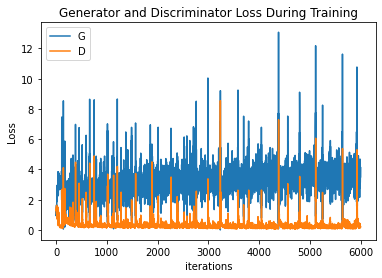

In [57]:
import torchvision.utils as vutils
from torch.optim.lr_scheduler import StepLR
import pdb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Number of channels
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100

# Create the generator and discriminator
netG = DCGAN_Generator().to(device)
netD = DCGAN_Discriminator().to(device)

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create latent vector to test the generator performance
fixed_noise = torch.randn(36, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

learning_rate = 0.0002
beta1 = 0.5

# Setup Adam optimizers for both G and D

################################
# Please fill in your code here:

optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))

################################



img_list = []
real_img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 10

  
def load_param(num_eps):
  model_saved = torch.load('/content/gan_{}.pt'.format(num_eps))
  netG.load_state_dict(model_saved['netG'])
  netD.load_state_dict(model_saved['netD'])

# GAN Training Loop
for epoch in range(num_epochs):
    for i, data in enumerate(gan_train_loader, 0):
        real = data[0].to(device)
        b_size = real.size(0)
        noise = torch.randn(b_size, nz, 1, 1, device=device)

        Valid_label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        Fake_label = torch.full((b_size,), fake_label, dtype=torch.float, device=device)

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        ################################
        # Please fill in your code here:
        optimizerD.zero_grad()
        loss_D, fake_imgs = loss_discriminator(netD, real, netG, noise, Valid_label, Fake_label, criterion, optimizerD)
        loss_D.backward()
        optimizerD.step()
        ################################

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################

        ################################
        # Please fill in your code here:
        # Figure out ------> fake
        optimizerG.zero_grad()
        loss_G = loss_generator(netD, netG, fake_imgs, Valid_label, criterion, optimizerG)
        loss_G.backward()
        optimizerG.step()
        ################################

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\t'
                  % (epoch, num_epochs, i, len(gan_train_loader),
                     loss_D.item(), loss_G.item()))

        # Save Losses for plotting later
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(gan_train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

        

plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


checkpoint = {'netG': netG.state_dict(),
              'netD': netD.state_dict()}
torch.save(checkpoint, 'gan_{}.pt'.format(num_epochs))




## Qualitative Visualisations

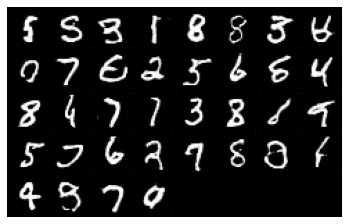

In [58]:
# Test GAN on a random sample and display on 6X6 grid
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6,6))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())